---
title: Linear Regression
subtitle: Orange Juice
date: 2025-02-26
from: markdown+emoji
execute: 
  eval: false
---

# Settings

## Required Libraries and Spark Session

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

### regression_table

In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: 95% CI Upper, 8: Exp(95% CI Lower), 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "95% CI Upper", "Exp(95% CI Lower)", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

### add_dummy_variables

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

### add_interaction_terms

In [ ]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

### compare_reg_models

In [ ]:
def compare_reg_models(models, assemblers, names=None):
    """
    Produces a single formatted table comparing multiple regression models.

    For each predictor (the union across models, ordered by first appearance), the table shows
    the beta estimate (with significance stars) from each model (blank if not used).
    For a predictor, if a model's outcome (model.getLabelCol()) starts with "log", the cell displays
    both the beta and its exponential (separated by " / "), except when the predictor's name includes "log_".
    (The intercept row does not display exp(.))

    Additional rows for Intercept, Observations, R², and RMSE are appended.

    The header's first column is labeled "Predictor", and subsequent columns are
    "y: [outcome] ([name])" for each model.

    The table is produced in grid format (with vertical lines). A dashed line (using '-' characters)
    is inserted at the top, immediately after the header, and at the bottom.
    Additionally, immediately after the Intercept row, the border line is replaced with one using '='
    (to appear as, for example, "+==============================================+==========================+...").

    Parameters:
        models (list): List of fitted LinearRegression models.
        assemblers (list): List of corresponding VectorAssembler objects.
        names (list, optional): List of model names; defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing the combined regression table.
    """
    # Default model names.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(models))]

    # For each model, get outcome and determine if that model is log-transformed.
    outcomes = [m.getLabelCol() for m in models]
    is_log_flags = [out.lower().startswith("log") for out in outcomes]

    # Build an ordered union of predictors based on first appearance.
    ordered_predictors = []
    for assembler in assemblers:
        for feat in assembler.getInputCols():
            if feat not in ordered_predictors:
                ordered_predictors.append(feat)

    # Helper for significance stars.
    def significance_stars(p):
        if p is None:
            return ""
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build rows for each predictor.
    rows = []
    for feat in ordered_predictors:
        row = [feat]
        for m, a, is_log in zip(models, assemblers, is_log_flags):
            feats_model = a.getInputCols()
            if feat in feats_model:
                idx = feats_model.index(feat)
                beta = m.coefficients.toArray()[idx]
                p_val = m.summary.pValues[idx] if m.summary.pValues is not None else None
                stars = significance_stars(p_val)
                cell = f"{beta:.3f}{stars}"
                # Only add exp(beta) if model is log and predictor name does NOT include "log_"
                if is_log and ("log_" not in feat.lower()):
                    cell += f" / {np.exp(beta):,.3f}"
                row.append(cell)
            else:
                row.append("")
        rows.append(row)

    # Build intercept row (do NOT compute exp(intercept)).
    intercept_row = ["Intercept"]
    for m in models:
        std_all = np.array(m.summary.coefficientStandardErrors)
        coeffs = m.coefficients.toArray()
        if len(std_all) == len(coeffs) + 1:
            intercept_p = m.summary.pValues[0] if m.summary.pValues is not None else None
        else:
            intercept_p = None
        sig = significance_stars(intercept_p)
        cell = f"{m.intercept:.3f}{sig}"
        intercept_row.append(cell)
    rows.append(intercept_row)

    # Add Observations row.
    obs_row = ["Observations"]
    for m in models:
        obs = m.summary.numInstances
        obs_row.append(f"{int(obs):,}")
    rows.append(obs_row)

    # Add R² row.
    r2_row = ["R²"]
    for m in models:
        r2_row.append(f"{m.summary.r2:.3f}")
    rows.append(r2_row)

    # Add RMSE row.
    rmse_row = ["RMSE"]
    for m in models:
        rmse_row.append(f"{m.summary.rootMeanSquaredError:.3f}")
    rows.append(rmse_row)

    # Build header: first column "Predictor", then for each model: "y: [outcome] ([name])"
    header = ["Predictor"]
    for out, name in zip(outcomes, names):
        header.append(f"y: {out} ({name})")

    # Create table string using grid format.
    table_str = tabulate(rows, headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(models))

    # Split into lines.
    lines = table_str.split("\n")

    # Create a dashed line spanning the full width.
    full_width = len(lines[0])
    dash_line = '-' * full_width
    # Create an equals line by replacing '-' with '='.
    eq_line = dash_line.replace('-', '=')

    # Insert a dashed line after the header row.
    lines = table_str.split("\n")
    # In grid format, header and separator are usually the first two lines.
    lines.insert(2, dash_line)

    # Insert an equals line after the Intercept row.
    for i, line in enumerate(lines):
        if line.startswith("|") and "Intercept" in line:
            if i+1 < len(lines):
                lines[i+1] = eq_line
            break

    # Add dashed lines at the very top and bottom.
    final_table = dash_line + "\n" + "\n".join(lines) + "\n" + dash_line

    return final_table

# Example usage:
# print(compare_reg_models([model_1, model_2, model_3],
#                          [assembler_1, assembler_2, assembler_3],
#                          ["Model 1", "Model 2", "Model 3"]))

### compare_rmse

In [ ]:
def compare_rmse(test_dfs, label_col, pred_col="prediction", names=None):
    """
    Computes and compares RMSE values for a list of test DataFrames.

    For each DataFrame in test_dfs, this function calculates the RMSE between the actual outcome
    (given by label_col) and the predicted value (given by pred_col, default "prediction"). It then
    produces a formatted table where the first column header is empty and the first row's first cell is
    "RMSE", with each model's RMSE in its own column.

    Parameters:
        test_dfs (list): List of test DataFrames.
        label_col (str): The name of the outcome column.
        pred_col (str, optional): The name of the prediction column (default "prediction").
        names (list, optional): List of model names corresponding to the test DataFrames.
                                Defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing a table that compares RMSE values for each test DataFrame,
        with one model per column.
    """
    # Set default model names if none provided.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(test_dfs))]

    rmse_values = []
    for df in test_dfs:
        # Create a column for squared error.
        df = df.withColumn("error_sq", pow(col(label_col) - col(pred_col), 2))
        # Calculate RMSE: square root of the mean squared error.
        rmse = df.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]
        rmse_values.append(rmse)

    # Build a single row table: first cell "RMSE", then one cell per model with the RMSE value.
    row = ["RMSE"] + [f"{rmse:.3f}" for rmse in rmse_values]

    # Build header: first column header is empty, then model names.
    header = [""] + names

    table_str = tabulate([row], headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(names))
    return table_str

# Example usage:
# print(compare_rmse([dtest_1, dtest_2, dtest_3], "log_sales", names=["Model 1", "Model 2", "Model 3"]))

### residual_plot

In [ ]:
def residual_plot(df, label_col, model_name):
    """
    Generates a residual plot for a given test dataframe.

    Parameters:
        df (DataFrame): Spark DataFrame containing the test set with predictions.
        label_col (str): The column name of the actual outcome variable.
        title (str): The title for the residual plot.

    Returns:
        None (displays the plot)
    """
    # Convert to Pandas DataFrame
    df_pd = df.select(["prediction", label_col]).toPandas()
    df_pd["residual"] = df_pd[label_col] - df_pd["prediction"]

    # Scatter plot of residuals vs. predicted values
    plt.scatter(df_pd["prediction"], df_pd["residual"], alpha=0.2, color="darkgray")

    # Use LOWESS smoothing for trend line
    smoothed = sm.nonparametric.lowess(df_pd["residual"], df_pd["prediction"])
    plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

    # Add reference line at y=0
    plt.axhline(y=0, color="red", linestyle="--")

    # Labels and title (model_name)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    model_name = "Residual Plot for " + model_name
    plt.title(model_name)

    # Show plot
    plt.show()

# Example usage:
# residual_plot(dtest_1, "log_sales", "Model 1")

# Data Preparation

In [ ]:
oj = pd.read_csv('https://bcdanl.github.io/data/dominick_oj_feat.csv')

## Log Transformation

In [ ]:
df = spark.createDataFrame(oj)
df = (
    df
    .withColumn("log_sales",
                log(df['sales']) )
    .withColumn("log_price",
                log(df['price']) )
)

## Training-Test Split

In [ ]:
dtrain, dtest = df.randomSplit([0.9, 0.1], seed = 1234)

## Adding Dummies

In [ ]:
dummy_cols_brand, ref_category_brand = add_dummy_variables('brand', 0)
dummy_cols_ad, ref_category_ad = add_dummy_variables('ad_status', 1)

Reference category (dummy omitted): dominicks
Reference category (dummy omitted): No Ad


## Adding Interaction Terms

In [ ]:
interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

# Model 1

In [ ]:
# assembling predictors
conti_cols = ["log_price"]

assembler_predictors = (
    conti_cols +
    dummy_cols_brand
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_1)
)

# making prediction
dtest_1 = model_1.transform(dtest_1)

# makting regression table
print( regression_table(model_1, assembler_1) )

+-------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| y: log_sales      |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper) |
+-------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| log_price         | -3.152 |           | ***  |      0.014 |   0.000 |       -3.179 |       -3.125 |                   |                   |
| brand_minute_maid |  0.876 |     2.400 | ***  |      0.017 |   0.000 |        0.842 |        0.909 |             2.321 |             2.483 |
| brand_tropicana   |  1.537 |     4.649 | ***  |      0.015 |   0.000 |        1.507 |        1.567 |             4.511 |             4.792 |
| Intercept         | 10.836 |           | ***  |      0.024 |         |       10.788 |              |            10.883 |                   |

# Model 2

In [ ]:
# assembling predictors
conti_cols = ["log_price"]

assembler_predictors = (
    conti_cols +
    dummy_cols_brand +
    interaction_cols_brand_price
)

assembler_2 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_2 = assembler_2.transform(dtrain)
dtest_2  = assembler_2.transform(dtest)

# training model
model_2 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_2)
)

# making prediction
dtest_2 = model_2.transform(dtest_2)

# makting regression table
print( regression_table(model_2, assembler_2) )

+-------------------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| y: log_sales                  |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper) |
+-------------------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| log_price                     | -3.410 |           | ***  |      0.044 |   0.000 |       -3.496 |       -3.324 |                   |                   |
| brand_minute_maid             |  0.868 |     2.382 | ***  |      0.049 |   0.000 |        0.771 |        0.964 |             2.163 |             2.623 |
| brand_tropicana               |  0.955 |     2.598 | ***  |      0.061 |   0.000 |        0.836 |        1.073 |             2.307 |             2.925 |
| brand_minute_maid_*_log_price |  0.095 |           |      |      0.0

# Model 3

In [ ]:
# assembling predictors
conti_cols = ["log_price"]

assembler_predictors = (
    conti_cols +
    dummy_cols_brand + dummy_cols_ad +
    interaction_cols_brand_ad_price
)

assembler_3 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_3 = assembler_3.transform(dtrain)
dtest_3  = assembler_3.transform(dtest)

# training model
model_3 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_3)
)

# making prediction
dtest_3 = model_3.transform(dtest_3)

# makting regression table
print( regression_table(model_3, assembler_3) )

+----------------------------------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| y: log_sales                                 |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper) |
+----------------------------------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| log_price                                    | -2.797 |           | ***  |      0.049 |   0.000 |       -2.894 |       -2.701 |                   |                   |
| brand_minute_maid                            |  0.029 |     1.029 |      |      0.054 |   0.561 |       -0.077 |        0.134 |             0.926 |             1.144 |
| brand_tropicana                              |  0.681 |     1.976 | ***  |      0.041 |   0.000 |        0.601 |        0.760 |             1.825 | 

# Model Comparison

## Betas

In [ ]:
print(
    compare_reg_models(
        [model_1, model_2, model_3],
        [assembler_1, assembler_2, assembler_3]
        )
    )

---------------------------------------------------------------------------------------------------------------------------------
+----------------------------------------------+--------------------------+--------------------------+--------------------------+
| Predictor                                    |   y: log_sales (Model 1) |   y: log_sales (Model 2) |   y: log_sales (Model 3) |
---------------------------------------------------------------------------------------------------------------------------------
+==============================================+==========================+==========================+==========================+
| log_price                                    |                -3.152*** |                -3.410*** |                -2.797*** |
+----------------------------------------------+--------------------------+--------------------------+--------------------------+
| brand_minute_maid                            |         0.876*** / 2.400 |         0.868*

## RMSEs

In [ ]:
# Create a new column for squared error
dtest_1 = dtest_1.withColumn("error_sq", pow(col("log_sales") - col("prediction"), 2))

# Calculate RMSE as the square root of the mean squared error
rmse_val_1 = dtest_1.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]

print(f'RMSE_1: {rmse_val_1:.3f}')

RMSE_1: 0.785


In [ ]:
print(compare_rmse([dtest_1, dtest_2, dtest_3], "log_sales"))

+------+-----------+-----------+-----------+
|      |   Model 1 |   Model 2 |   Model 3 |
+======+===========+===========+===========+
| RMSE |     0.785 |     0.783 |     0.682 |
+------+-----------+-----------+-----------+


## Residual Plots

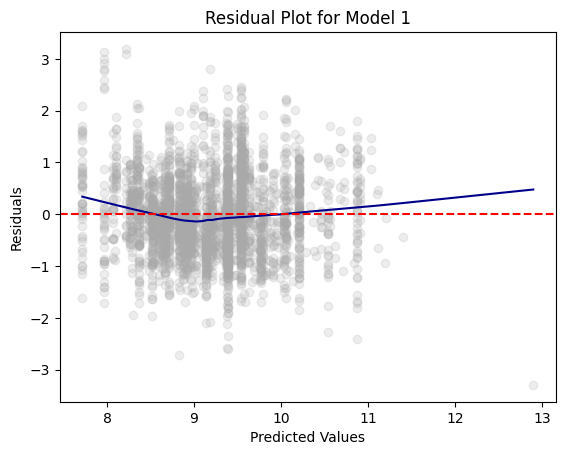

In [ ]:
residual_plot(dtest_1, "log_sales", "Model 1")

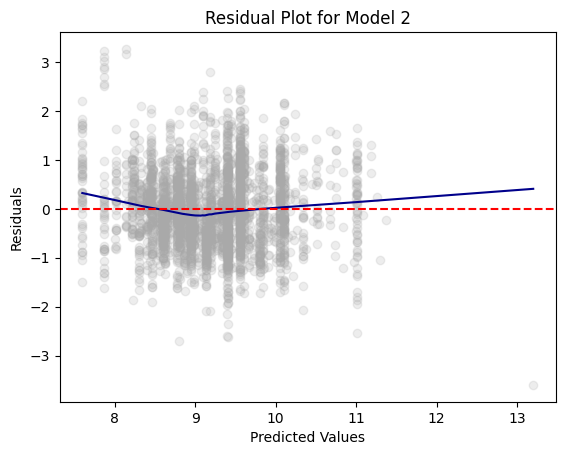

In [ ]:
residual_plot(dtest_2, "log_sales", "Model 2")

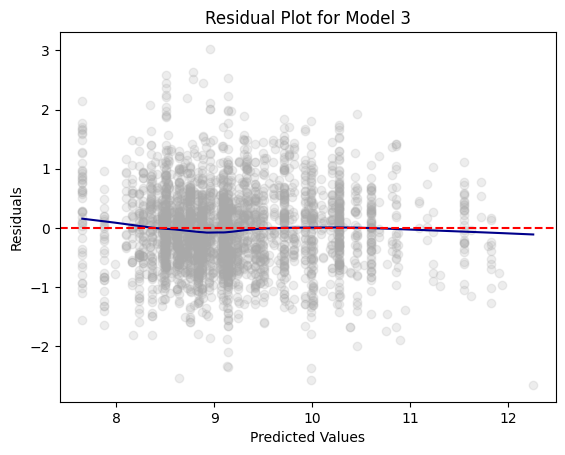

In [ ]:
residual_plot(dtest_3, "log_sales", "Model 3")